In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
import os
import certifi
import json
from torch.optim.lr_scheduler import StepLR

In [2]:
os.environ['SSL_CERT_FILE'] = certifi.where()

data augmentation and normalization for training

In [3]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


data normalization for testing

In [4]:
transform_test = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

load dataset

In [5]:
data_path = './data_cifar/'
cifar10_train = CIFAR10(data_path, train=True, download=True, transform=transform_train)
cifar10_test = CIFAR10(data_path, train=False, download=True, transform=transform_test)

100%|██████████| 170498071/170498071 [00:03<00:00, 46460592.39it/s]


Extracting ./data_cifar/cifar-10-python.tar.gz to ./data_cifar/
Files already downloaded and verified


split trainset to train an validation sets

In [6]:
train_size = int(0.9 * len(cifar10_train))
val_size = len(cifar10_train) - train_size
train_dataset, val_dataset = random_split(cifar10_train, [train_size, val_size])

define dataloaders

In [7]:
batch_size = 128
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False, num_workers=2)

define model

In [18]:
class ResNet20(nn.Module):
    def __init__(self, n_classes):
        super(ResNet20, self).__init__()

        self.dropout_percentage = 0.5
        self.relu = nn.ReLU(inplace=True)

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        self.batchnorm1 = nn.BatchNorm2d(16)

        self.conv2_1_1 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        self.batchnorm2_1_1 = nn.BatchNorm2d(16)
        self.conv2_1_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        self.batchnorm2_1_2 = nn.BatchNorm2d(16)

        self.conv2_2_1 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        self.batchnorm2_2_1 = nn.BatchNorm2d(16)
        self.conv2_2_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        self.batchnorm2_2_2 = nn.BatchNorm2d(16)


        self.conv3_1_1 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        self.batchnorm3_1_1 = nn.BatchNorm2d(32)
        self.conv3_1_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        self.batchnorm3_1_2 = nn.BatchNorm2d(32)
        self.concat_adjust_3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(1, 1), stride=(2, 2), padding=(0, 0), bias=False)

        self.conv3_2_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        self.batchnorm3_2_1 = nn.BatchNorm2d(32)
        self.conv3_2_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        self.batchnorm3_2_2 = nn.BatchNorm2d(32)


        self.conv4_1_1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        self.batchnorm4_1_1 = nn.BatchNorm2d(64)
        self.conv4_1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        self.batchnorm4_1_2 = nn.BatchNorm2d(64)
        self.concat_adjust_4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, 1), stride=(2, 2), padding=(0, 0), bias=False)

        self.conv4_2_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        self.batchnorm4_2_1 = nn.BatchNorm2d(64)
        self.conv4_2_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        self.batchnorm4_2_2 = nn.BatchNorm2d(64)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(in_features=64, out_features=n_classes)

    def forward(self, x):

        x = self.relu(self.batchnorm1(self.conv1(x)))
        x = self.relu(self.batchnorm2_1_1(self.conv2_1_1(x)))   
        x = self.batchnorm2_1_2(self.conv2_1_2(x))              
        x = self.relu(self.batchnorm2_2_1(self.conv2_2_1(x)))    
        op2 = self.batchnorm2_2_2(self.conv2_2_2(x))             
        x = self.relu(self.batchnorm3_1_1(self.conv3_1_1(op2))) 
        x = self.batchnorm3_1_2(self.conv3_1_2(x))              
        op2 = self.concat_adjust_3(op2)                         
        op3 = self.relu(x + op2)
        x = self.relu(self.batchnorm3_2_1(self.conv3_2_1(op3)))  
        op3 = self.batchnorm3_2_2(self.conv3_2_2(x))             
        x = self.relu(self.batchnorm4_1_1(self.conv4_1_1(op3))) 
        x = self.batchnorm4_1_2(self.conv4_1_2(x))               
        op3 = self.concat_adjust_4(op3)                          
        op4 = self.relu(x + op3)
        x = self.relu(self.batchnorm4_2_1(self.conv4_2_1(op4)))  
        op4 = self.batchnorm4_2_2(self.conv4_2_2(x))             
        x = self.avgpool(op4)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

initialize the model, loss function, and optimizer

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_classes = 10
model = ResNet20(n_classes=n_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

training function

In [21]:
def train(model, device, trainloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(trainloader.dataset)
    train_accuracy = 100. * correct / total

    return train_loss, train_accuracy

evaluate function

In [22]:
def evaluate(model, device, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    average_loss = total_loss / len(dataloader.dataset)
    accuracy = 100. * correct / total

    return average_loss, accuracy

create directory for saving model

In [23]:
os.makedirs('./model_checkpoints', exist_ok=True)

save configurations

In [24]:
config = {
    "batch_size": 128,
    "learning_rate": 0.001,
    "epochs": 50,
    "transform_train": str(transform_train),
    "transform_test": str(transform_test),
    "device": str(device)
}
with open('./model_checkpoints/config.json', 'w') as f:
    json.dump(config, f, indent=4)

training phase

In [25]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 50
patience = 7
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, device, trainloader, criterion, optimizer)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    val_loss, val_accuracy = evaluate(model, device, valloader, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    scheduler.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_resnet20.pth')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break

Epoch 1/50, Train Loss: 1.8612, Train Accuracy: 30.36%, Val Loss: 1.7551, Val Accuracy: 36.36%
Epoch 2/50, Train Loss: 1.6432, Train Accuracy: 39.64%, Val Loss: 1.5646, Val Accuracy: 41.90%
Epoch 3/50, Train Loss: 1.5090, Train Accuracy: 45.70%, Val Loss: 1.5502, Val Accuracy: 43.82%
Epoch 4/50, Train Loss: 1.4184, Train Accuracy: 49.27%, Val Loss: 1.4654, Val Accuracy: 48.10%
Epoch 5/50, Train Loss: 1.3521, Train Accuracy: 51.58%, Val Loss: 1.4287, Val Accuracy: 47.46%
Epoch 6/50, Train Loss: 1.3048, Train Accuracy: 53.64%, Val Loss: 1.3885, Val Accuracy: 49.28%
Epoch 7/50, Train Loss: 1.2545, Train Accuracy: 55.59%, Val Loss: 1.3103, Val Accuracy: 54.50%
Epoch 8/50, Train Loss: 1.2108, Train Accuracy: 57.20%, Val Loss: 1.3757, Val Accuracy: 52.96%
Epoch 9/50, Train Loss: 1.1956, Train Accuracy: 57.78%, Val Loss: 1.2640, Val Accuracy: 54.98%
Epoch 10/50, Train Loss: 1.1615, Train Accuracy: 59.26%, Val Loss: 1.2484, Val Accuracy: 56.22%
Epoch 11/50, Train Loss: 1.0754, Train Accuracy: 

test phase

In [27]:
model.load_state_dict(torch.load('best_resnet20.pth'))
test_loss, test_accuracy = evaluate(model, device, testloader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.6872, Test Accuracy: 76.40%


plotting

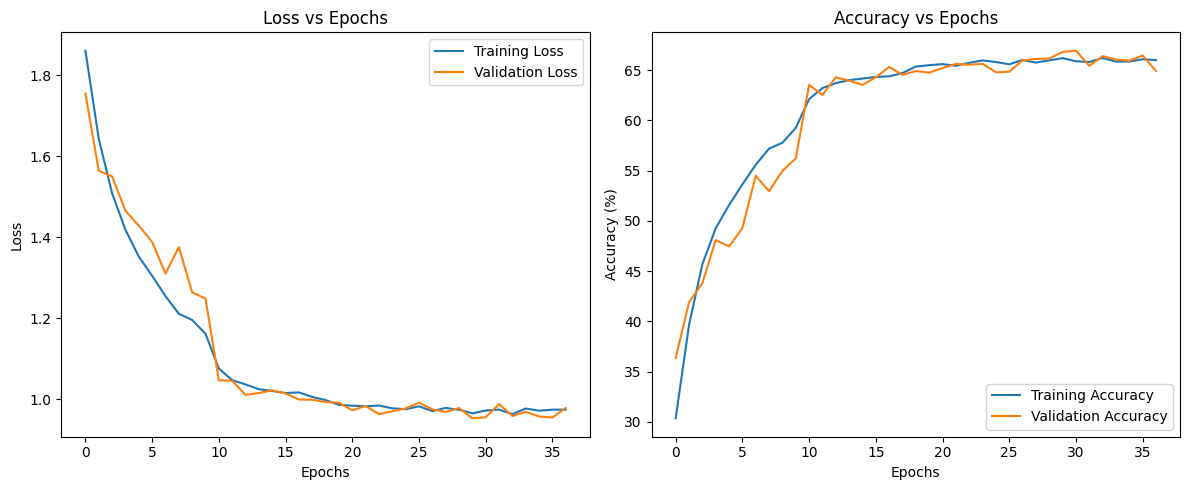

In [28]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()